# Inspecting the Results of the Arcelik Survey Round 1

In [1]:
import os
import pickle
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RESULTS_DICT_PATH = os.path.abspath("./survey_results_processed/fused_results.pkl")
RECIPES_WITH_ANSWERS_PATH = os.path.abspath("./survey_results_processed/survey_samples_with_answers.pkl")

#### Load Data

In [3]:
with open(RESULTS_DICT_PATH, "rb") as results_dict_file:
    results = pickle.load(results_dict_file)

with open (RECIPES_WITH_ANSWERS_PATH, "rb") as recipes_with_answers_file:
    recipes_with_answers = pickle.load(recipes_with_answers_file)

In [4]:
print(list(results.items())[0])

(0, {'individual_responses': {'fit': [1, 1, 1, 1, 1], 'tastechange': [0, 1, 0, 1, 0], 'nutruientschange': [0], 'processchange': [0, 0, 0, 0, 0], 'categorychange': [1, 0, 0, 0, 0], 'mainingr': [], 'selection': ['Pork belly', 'Pork belly', 'Pork belly', 'Pork belly', 'Pork loin'], 'usersuggestion': []}, 'consensual_answers': {'fit': 1, 'tastechange': 0, 'nutruientschange': None, 'processchange': 0, 'categorychange': 0, 'mainingr': [], 'selection': 'Pork belly', 'usersuggestion': []}})


In [5]:
print(list(results.items())[2][1]["consensual_answers"])

{'fit': 1, 'tastechange': 1, 'nutruientschange': None, 'processchange': 0, 'categorychange': 0, 'mainingr': [], 'selection': 'Ground beef', 'usersuggestion': ['ground goat']}


In [7]:
for _, result in list(results.items()):
    consensual_answers = result["consensual_answers"]
    if consensual_answers["selection"] == "None":
        print(consensual_answers)
        break

In [10]:
def get_numbers_for_consensus(results, question):
    no_consensus = 0
    consensus_is_yes = 0
    conseneus_is_no = 0
    errors = 0
    avg_number_of_responses = 0
    fewer_than_2_responses = 0
    avg_positive_to_negative_rate = 0
    avg_negative_to_positive_quotient = 0

    for result in list(results.items()):
        individual_answers = result[1]["individual_responses"][question]
        consensual_answers = result[1]["consensual_answers"][question]

        avg_number_of_responses += len(individual_answers)
        if len(individual_answers) <= 1:
            fewer_than_2_responses += 1

        if len(individual_answers) > 0:
            avg_negative_to_positive_quotient += 1
            n_negative_ansers = len([answer for answer in individual_answers if answer == 0])
            n_positive_answers = len([answer for answer in individual_answers if answer == 1])
            if n_negative_ansers == 0:
                avg_positive_to_negative_rate += 1 # we can assume all answers must be positive if there is no negative answer, because we already checked the number of answer such not both nor negative can be cnt 0
            else:
                avg_positive_to_negative_rate += (n_positive_answers / n_negative_ansers) / len(individual_answers)

        if consensual_answers is None:
            no_consensus += 1
        elif consensual_answers == 1:
            consensus_is_yes += 1
        elif consensual_answers == 0:
            conseneus_is_no += 1
        else:
            errors += 1

    avg_number_of_responses = avg_number_of_responses / len(list(results.items()))
    if avg_negative_to_positive_quotient > 0:
        avg_positive_to_negative_rate = avg_positive_to_negative_rate / avg_negative_to_positive_quotient

    return no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate

def getFleissKappaSingleQ(results, question):

    # formular kappa: (Ao - Ae) / (1 - Ae)

    # formula observed agreement: Ao = 1/(i*c*(c-1) * sum_i(sum_k(n_ik * (n_ik - 1))))

    A_o = 0

    i = len([k for k, v in list(results.items()) if len(v["individual_responses"]) > 0])
    for result in list(results.items()):
        individual_answers = result[1]["individual_responses"][question]
        c = len(individual_answers)
        if c <= 0:
            continue
        q = i * c * (c - 1)
        if q <= 0:
            return 0

        n_pos_labels = len([k for k in individual_answers if k == 1])
        n_neg_labels = len([k for k in individual_answers if k == 0])
        k_1 = n_pos_labels * (n_pos_labels - 1)
        k_2 = n_neg_labels * (n_neg_labels - 1)
        summand = (k_1 + k_2) / q
        A_o += summand

    # expected agreement: for binary response: 0.5 * 0.5 = 0.25 (for individual question)
    A_e = 0.25

    kappa = (A_o - A_e) / (1 - A_e)

    return kappa

def getFleissKappa(results):
    pass

## Q1: Does the suggested substitution fit the recipe?

In [11]:

question = "fit"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q1 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 38
nr of answers where consens was yes: 434
nr of answers where consens was no: 29
nr of error cases: 0
on average, there were 3.8962075848303392 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.8275999999999997


## Q2: Does the suggested substitution constitute a major taste change?

In [9]:
question = "tastechange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q2 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 94
nr of answers where consens was yes: 383
nr of answers where consens was no: 24
nr of error cases: 0
on average, there were 3.8922155688622753 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.7125666666666663


## Q3: Does the suggested substitution constitute a change in the nutritional profile of the recipe?

In [10]:
question = "nutruientschange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q3 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 472
nr of answers where consens was yes: 8
nr of answers where consens was no: 21
nr of error cases: 0
on average, there were 0.9660678642714571 responses per question
nr of questions with fewer than 2 answers: 460
on average, the rate of positive responses to negative responses was: 0.41456422018348615


## Q4: Does the suggested substitution require a major change in the cooking instructions?

In [11]:
question = "processchange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q4 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 67
nr of answers where consens was yes: 89
nr of answers where consens was no: 345
nr of error cases: 0
on average, there were 3.8902195608782435 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.19993333333333305


## Q5: Does the suggested substitution constitute a change in the food category (e.g. making the recipe vegetarian)?

In [12]:
question = "categorychange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q5 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 60
nr of answers where consens was yes: 80
nr of answers where consens was no: 361
nr of error cases: 0
on average, there were 3.8602794411177643 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.1889666666666666


## Q6: Is __ the main ingredient?

## Q7: Which is the best substitution?

In [13]:
question = "selection"

no_consensus = 0
ingredient_consensus = 0
other_consensus = 0
for result in list(results.items()):
    consensual_answers = result[1]["consensual_answers"]
    fit_answer = consensual_answers[question]
    if fit_answer == "other":
        other_consensus += 1
    elif fit_answer is None:
        no_consensus += 1
    else:
        ingredient_consensus += 1

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was 'other': {other_consensus}")
print(f"nr of answers where consens was a specific ingredient: {ingredient_consensus}")

nr of answers without consens: 239
nr of answers where consens was 'other': 0
nr of answers where consens was a specific ingredient: 262


## q8: If none of the suggested ingredients were good, which alternative do you suggest?

## Summary

[Text(0.5, 0, 'no agreement'),
 Text(1.5, 0, 'agreement pos.'),
 Text(2.5, 0, 'agreement neg.'),
 Text(3.5, 0, 'nr q with nr. responses<=1')]

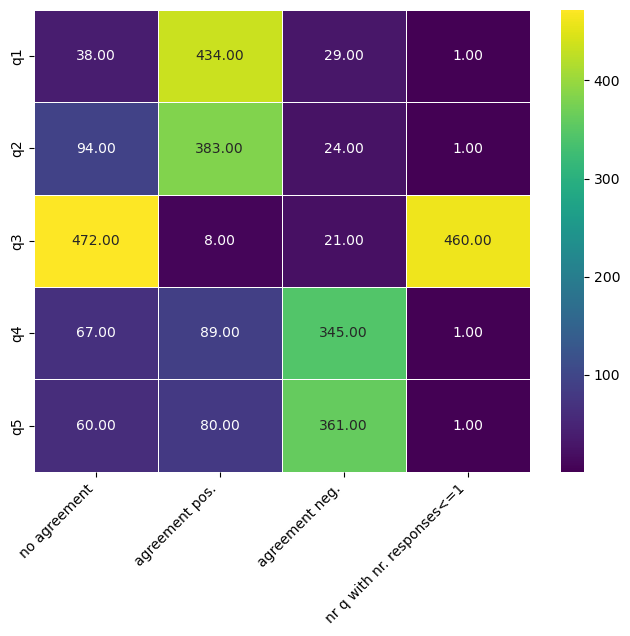

In [14]:
df_q_1_to_5 = pd.DataFrame([q1, q2, q3, q4, q5], index = ["q1", "q2", "q3", "q4", "q5"], columns = ["no agreement", "agreement pos.", "agreement neg.", "errors", "avg. nr. responses", "nr q with nr. responses<=1", "avg. pos-neg. rate"])
# print(df_q_1_to_5.head(2))
# print(df_q_1_to_5.shape)

df_q_1_to_5_a = df_q_1_to_5.iloc[:, [0,1,2,5]]
df_q_1_to_5_b = df_q_1_to_5.iloc[:, [4]]
df_q_1_to_5_c = df_q_1_to_5.iloc[:, [6]]

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df_q_1_to_5_a, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

[Text(0.5, 0, 'avg. nr. responses')]

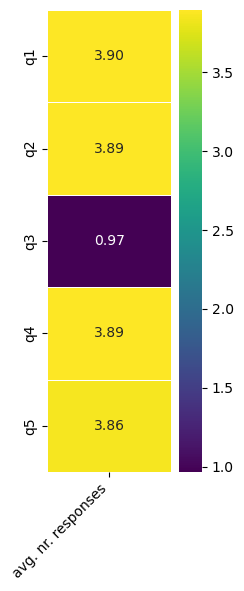

In [15]:
plt.figure(figsize=(2, 6))
heatmap = sns.heatmap(df_q_1_to_5_b, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

[Text(0.5, 0, 'avg. pos-neg. rate')]

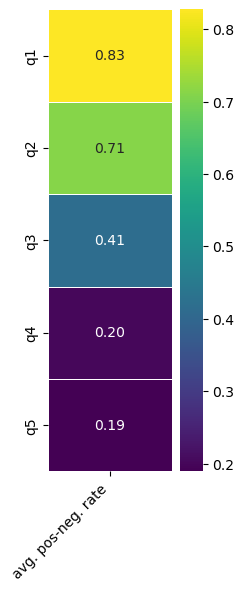

In [16]:
plt.figure(figsize=(2, 6))
heatmap = sns.heatmap(df_q_1_to_5_c, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

## How are answers distributed for substitution tuples?

In [17]:
answers_per_recipe_sub_pair = {}

for recipe in recipes_with_answers:
    key = (recipe["sample_sub"][0], recipe["sample_sub"][1])
    if key not in answers_per_recipe_sub_pair.keys():
        answers_per_recipe_sub_pair[key] = {}
    consensual_answers = recipe['consensual_answers']
    for question, consensual_answer in list(consensual_answers.items()):
        if question not in answers_per_recipe_sub_pair[key].keys():
            answers_per_recipe_sub_pair[key][question] = []
        answers_per_recipe_sub_pair[key][question].append(consensual_answer)

print("done")

done


### create a dictionary and dataframe for answers per substitution tuple

In [18]:
binary_questions = ['fit', 'tastechange', 'nutruientschange', 'processchange', 'categorychange']
n_expected_answers = 10

answer_counts_per_sub_tuple = {}
for sub_tuple, answers_per_question in list(answers_per_recipe_sub_pair.items()):
    answer_counts_per_sub_tuple[sub_tuple] = {}
    for question, answers in list(answers_per_question.items()):
        if question not in binary_questions:
            continue
        n_no_consensus = len([answer for answer in answers if answer is None])
        n_consensus_positive = len([answer for answer in answers if answer == 1])
        n_consensus_negative = len([answer for answer in answers if answer == 0])
        answer_counts_per_sub_tuple[sub_tuple][question] = {}
        answer_counts_per_sub_tuple[sub_tuple][question]["consensus_positive"] = n_consensus_positive
        answer_counts_per_sub_tuple[sub_tuple][question]["consensus_negative"] = n_consensus_negative
        answer_counts_per_sub_tuple[sub_tuple][question]["no_consensus"] = n_no_consensus

#print(list(answer_counts_per_sub_tuple.values())[0])

In [19]:
df_a_per_sub_tup = pd.DataFrame(answer_counts_per_sub_tuple)

# print(df_a_per_sub_tup.shape)
# print(df_a_per_sub_tup.head(2))

In [20]:
binary_questions = ['fit', 'tastechange', 'nutruientschange', 'processchange', 'categorychange']
avg_answ_per_sub_tuple = {question: {"consensus_positive": 0, "consensus_negative": 0, "no_consensus": 0} for question in binary_questions}
for sub_tuple, questions in answer_counts_per_sub_tuple.items():
    for question, answer in questions.items():
        for answer, value in answer.items():
            avg_answ_per_sub_tuple[question][answer] += value

for question, answers in list(avg_answ_per_sub_tuple.items()):
    for answer, value in answers.items():
        avg_answ_per_sub_tuple[question][answer] = value / len(list(answer_counts_per_sub_tuple.keys()))

print("Average number of results per substitution tuple:")
for question, answers in avg_answ_per_sub_tuple.items():
    print(f"Question: {question}")
    for answer, value in answers.items():
        print(f"    Answer: {answer} - average count: {value}")


Average number of results per substitution tuple:
Question: fit
    Answer: consensus_positive - average count: 8.68
    Answer: consensus_negative - average count: 0.58
    Answer: no_consensus - average count: 0.74
Question: tastechange
    Answer: consensus_positive - average count: 7.66
    Answer: consensus_negative - average count: 0.48
    Answer: no_consensus - average count: 1.86
Question: nutruientschange
    Answer: consensus_positive - average count: 0.16
    Answer: consensus_negative - average count: 0.42
    Answer: no_consensus - average count: 9.42
Question: processchange
    Answer: consensus_positive - average count: 1.78
    Answer: consensus_negative - average count: 6.9
    Answer: no_consensus - average count: 1.32
Question: categorychange
    Answer: consensus_positive - average count: 1.6
    Answer: consensus_negative - average count: 7.22
    Answer: no_consensus - average count: 1.18


[Text(0.5, 0, 'substition fits'),
 Text(1.5, 0, 'taste changes'),
 Text(2.5, 0, 'nutritional profile changes'),
 Text(3.5, 0, 'cooking process changes'),
 Text(4.5, 0, 'food category changes')]

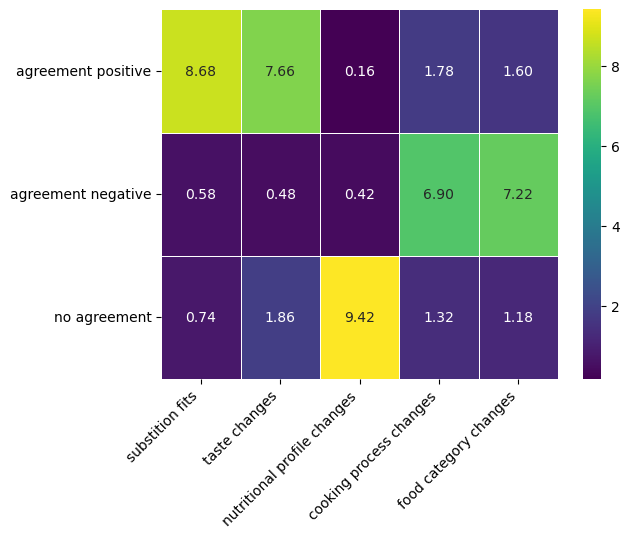

In [21]:
df_avg_ans_per_sub_tpl = pd.DataFrame(avg_answ_per_sub_tuple)
heatmap = sns.heatmap(df_avg_ans_per_sub_tpl, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)

new_x_labels = ['substition fits', 'taste changes', 'nutritional profile changes', "cooking process changes", "food category changes"]
heatmap.set_xticklabels(new_x_labels)

new_y_labels = ['agreement positive', 'agreement negative', 'no agreement']
heatmap.set_yticklabels(new_y_labels)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

In [22]:
binary_questions = ['fit', 'tastechange', 'nutruientschange', 'processchange', 'categorychange']
n_expected_answers = 10

answer_counts_per_sub_tuple_ = {question: {"consensus_positive": {}, "consensus_negative": {}, "no_consensus": {}} for question in binary_questions}
for sub_tuple, answers_per_question in list(answers_per_recipe_sub_pair.items()):
    for question, answers in list(answers_per_question.items()):
        if question not in binary_questions:
            continue
        n_consensus_positive = len([answer for answer in answers if answer == 1])
        n_consensus_negative = len([answer for answer in answers if answer == 0])
        n_no_consensus = len([answer for answer in answers if answer is None])
        answer_counts_per_sub_tuple_[question]["consensus_positive"][sub_tuple] = n_consensus_positive
        answer_counts_per_sub_tuple_[question]["consensus_negative"][sub_tuple] = n_consensus_negative
        answer_counts_per_sub_tuple_[question]["no_consensus"][sub_tuple] = n_no_consensus


In [23]:
df_q_a_sub_tup = pd.DataFrame(answer_counts_per_sub_tuple_)

In [24]:
print(df_q_a_sub_tup.index)
print(df_q_a_sub_tup.columns)
print(df_q_a_sub_tup.head(2))

Index(['consensus_positive', 'consensus_negative', 'no_consensus'], dtype='object')
Index(['fit', 'tastechange', 'nutruientschange', 'processchange',
       'categorychange'],
      dtype='object')
                                                                  fit  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 10, ('t...   
consensus_negative  {('white_wine', 'white_wine_vinegar'): 0, ('to...   

                                                          tastechange  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 3, ('to...   
consensus_negative  {('white_wine', 'white_wine_vinegar'): 2, ('to...   

                                                     nutruientschange  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 0, ('to...   
consensus_negative  {('white_wine', 'white_wine_vinegar'): 1, ('to...   

                                                        processchange  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 0, ('to...

In [25]:
answer_counts_per_sub_tuple_flattened = {}
for tuple, answer_counts in list(answer_counts_per_sub_tuple.items()):
  answer_counts_per_sub_tuple_flattened[tuple] = {}
  for question, answer in list(answer_counts.items()):
    for answer_type, value in list(answer.items()):
      key = "" + question + "_" + answer_type
      answer_counts_per_sub_tuple_flattened[tuple][key] = value

In [26]:
tuples_per_answer = {'fit_consensus_positive': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'fit_consensus_negative': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'fit_no_consensus': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10 : []},
  'tastechange_consensus_positive': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'tastechange_consensus_negative': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'tastechange_no_consensus': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'nutruientschange_consensus_positive': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'nutruientschange_consensus_negative': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'nutruientschange_no_consensus': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'processchange_consensus_positive': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'processchange_consensus_negative': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'processchange_no_consensus': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'categorychange_consensus_positive': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'categorychange_consensus_negative': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []},
  'categorychange_no_consensus': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}}

for tuple, answer in list(answer_counts_per_sub_tuple_flattened.items()):
    for key, value in list(answer.items()):
        tuples_per_answer[key][value].append(tuple)


<Axes: >

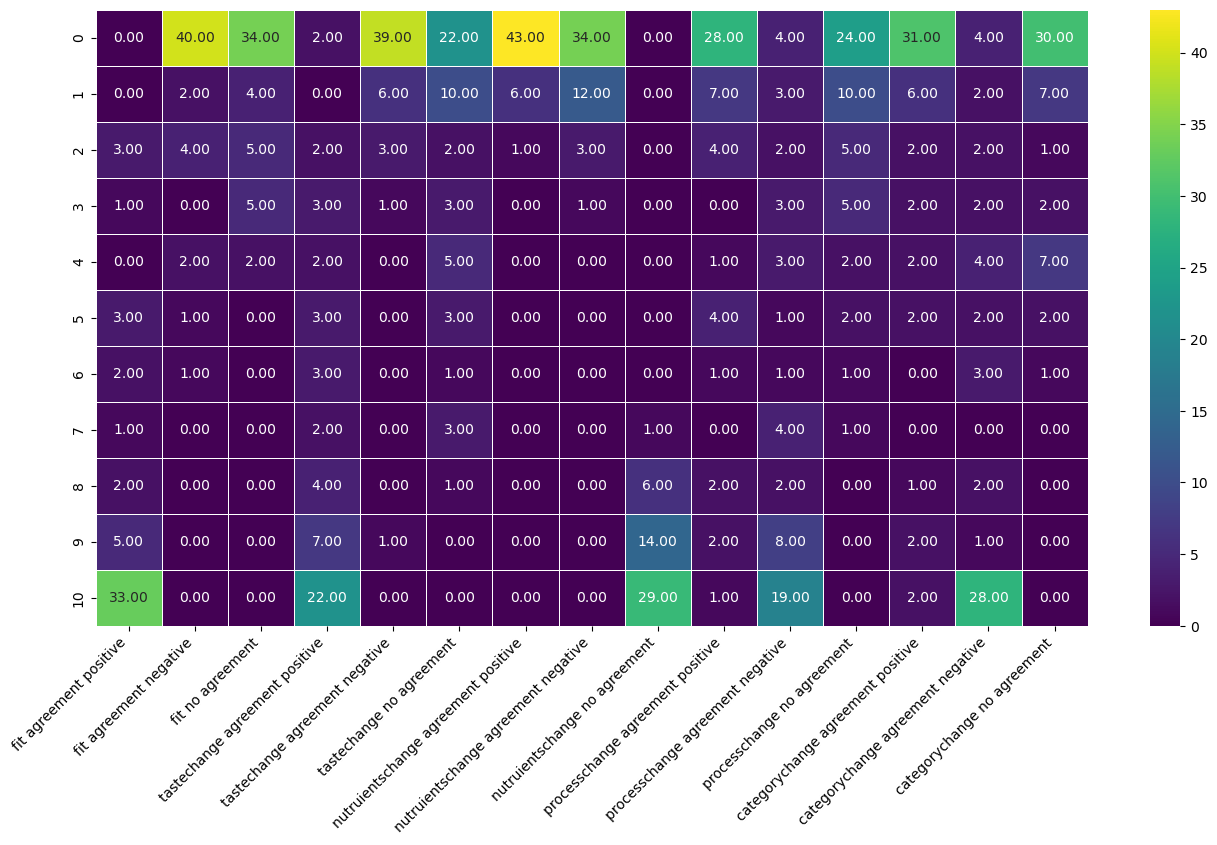

In [27]:
tuple_cnt_per_answer = {answer: {cnt: len(tuples) for cnt, tuples in list(tuples_per_cnt.items())} for answer, tuples_per_cnt in list(tuples_per_answer.items())}
df_tuples_per_answer = pd.DataFrame(tuple_cnt_per_answer)
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(df_tuples_per_answer, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)

heatmap.set_xticklabels([label.replace("_", " ").replace("consensus", "agreement") for label in list(tuple_cnt_per_answer.keys())])
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
heatmap

In [28]:
print(tuples_per_answer['fit_consensus_positive'][2])
print(tuples_per_answer['fit_consensus_positive'][3])
print(tuples_per_answer['fit_consensus_positive'][4])
print(tuples_per_answer['fit_consensus_positive'][5])

[('ricotta_cheese', 'fresh_spinach'), ('sour_cream', 'chive'), ('zucchini', 'banana')]
[('egg', 'tofu')]
[]
[('egg', 'banana'), ('pork_tenderloin', 'shrimp'), ('ground_beef', 'roast_beef')]


In [29]:
print(tuples_per_answer['processchange_consensus_positive'][10])
print(tuples_per_answer['processchange_consensus_positive'][9])
print(tuples_per_answer['processchange_consensus_positive'][8])
print(tuples_per_answer['categorychange_consensus_positive'][10])
print(tuples_per_answer['categorychange_consensus_positive'][9])
print(tuples_per_answer['categorychange_consensus_positive'][8])


[('ground_beef', 'black_bean')]
[('pork_tenderloin', 'shrimp'), ('ground_beef', 'roast_beef')]
[('ricotta_cheese', 'fresh_spinach'), ('egg', 'tofu')]
[('ground_beef', 'black_bean'), ('ground_turkey', 'mushroom')]
[('extra_large_shrimp', 'chicken'), ('pork_tenderloin', 'shrimp')]
[('boneless_skinless_chicken_breast', 'shrimp')]


# Inter-Annotator Agreement

In [34]:
single_q_IAAs = {}
for question in binary_questions:
    single_q_IAAs[question] = getFleissKappaSingleQ(results, question)
print(single_q_IAAs)

{'fit': 0.7345752938567429, 'tastechange': 0.5276114437791163, 'nutruientschange': 0, 'processchange': 0.5859835883788076, 'categorychange': 0.6702594810379344}


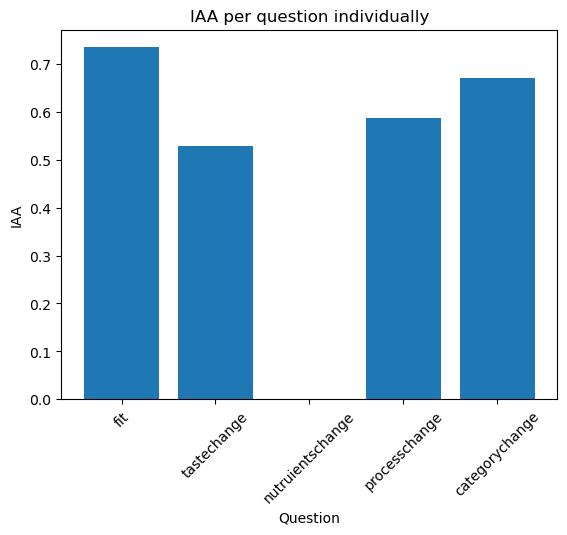

In [31]:
single_q_IAAs

keys = list(single_q_IAAs.keys())
values = list(single_q_IAAs.values())

plt.bar(keys, values)
plt.xlabel('Question')
plt.ylabel('IAA')
plt.title('IAA per question individually')
plt.xticks(rotation=45)
plt.show()

## Confusion Matrix for tetrachoric correlation

In [32]:
def get_tetrachoric_correlation(results, var_a, var_b):
    ab_11 = 0
    ab_00 = 0
    ab_10 = 0
    ab_01 = 0

    for _, result in results.items():
        a = result["individual_responses"][var_a]
        b = result["individual_responses"][var_b]


        l = min([len(a), len(b)]) # can only consider samples where the annotator answered both questions
        for i in range(l):
            val_a = a[i]
            val_b = b[i]
            if val_a == 1 and val_b == 1:
                ab_11 += 1
            elif val_a == 0 and val_b == 0:
                ab_00 += 1
            elif val_a == 0 and val_b == 1:
                ab_10 += 1
            elif val_a == 1 and val_b == 0:
                ab_01 += 1

    r_t = math.cos(math.pi/(1 + math.sqrt((ab_00 * ab_11) / (ab_01 * ab_10))))
    return r_t


meaningful_binary_questions = ['fit', 'tastechange', 'processchange', 'categorychange']
t_corrs = {}
for i in range(len(meaningful_binary_questions)):
    for j in range(i, len(meaningful_binary_questions)):
        if i == j:
            t_corrs[(meaningful_binary_questions[i], meaningful_binary_questions[i])] = 1
            continue

        var_a = meaningful_binary_questions[i]
        var_b = meaningful_binary_questions[j]
        t_corr = get_tetrachoric_correlation(results, var_a, var_b)
        t_corrs[(var_a, var_b)] = t_corr

t_corrs_matrix = {}
for question in meaningful_binary_questions:
    t_corrs_matrix[question] = {}
    for question_2 in meaningful_binary_questions:
        key_tuple = (question, question_2) if (question, question_2) in list(t_corrs.keys()) else (question_2, question)
        t_corr = t_corrs[key_tuple]
        t_corrs_matrix[question][question_2] = t_corr

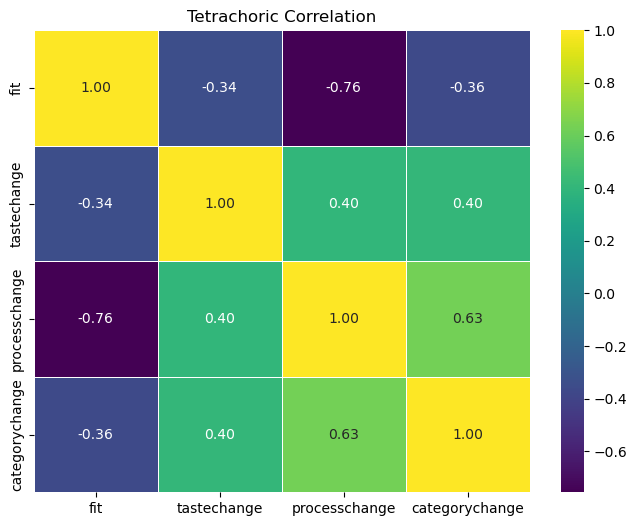

In [33]:
df_matrix = pd.DataFrame.from_dict(t_corrs_matrix, orient='index')
plt.figure(figsize=(8, 6))
sns.heatmap(df_matrix, annot=True, cmap='viridis', linewidths=.5, fmt=".2f")

plt.title('Tetrachoric Correlation')

plt.show()

In [13]:
egg_banana_subs = []
for recipe in recipes_with_answers:
    if recipe['sample_sub'] == ['egg', 'banana']:
        egg_banana_subs.append(recipe)
egg_banana_subs

[{'id': '39d7b58395',
  'ingredients': [['vegetable_oil',
    'vegetable_oil_cooking_spray',
    'castor_oil'],
   ['sugar'],
   ['vanilla'],
   ['egg', 'eggs', 'duck_egg'],
   ['baking_powder'],
   ['cocoa_powder', 'chocolate_malt_powder'],
   ['salt', 'vegetable_salt', 'low_sodium_salt'],
   ['flour']],
  'subs': ['vegetable_oil', 'butter'],
  'instructions': ['Preheat oven to 350.',
   'Mix oil and sugar until well blended.',
   'Add eggs and vanilla; stir just until blended.',
   'Mix all dry ingredients in a separate bowl.',
   'Stir dry ingredients into the oil/sugar mixture.',
   'Pour into greased 9 x 9 square pan.',
   'Bake for 20 minutes or until sides just start to pull away from the pan.',
   'Cool completely before cutting.',
   'Note: I usually double the recipe and bake in a 9 x 13 pan.',
   'If you double the recipe, you will need to cook longer than 20 minutes.'],
  'title': 'The Best Brownies',
  'original_ingredients': ['12 cup vegetable oil',
   '1 cup sugar',
   '